# To predict whether a customer will subscribe a short term deposit or not?

The Entire solution below is divided into 6 sub heads. I am listing them down in the begenning to give the evaluator a jist as to what all I have prepared.

1. Loading required dataset and the libraries.
2. Structuring the Data - Missing values check and Outlier treatment.
3. Exploratory Data Analysis - This has been done on 6 key metric and their requisite combinations along with a    correlation matrix. Post every metric I have included my observations.
4. Feature Enginerring
   4.1- Feature Selection with PCA
5. Model Training
6. Making a Prediction

# 1. Loading required dataset and the libraries.

In [1]:
import pandas as pd 
import matplotlib as style
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.plotly as py
import plotly.graph_objs as go
from pandas.plotting import scatter_matrix
from pandas.plotting import bootstrap_plot
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import Imputer
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Load data file
dataset=pd.read_csv('/Users/ishanbabbar/Documents/Booking_Interview/Input_Data.txt',delimiter="\t")
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
dataset.shape

(45211, 17)

# 2. Structuring the Data - Missing values check , Outlier treatment and Categorical vs Non categorical variables.

In [4]:
# To check if there are any missing values. This could be helpful is seeing the numeric data trends going forward
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
continuous_vars = dataset.describe().columns
categorical_vars = dataset.describe(include=["object"]).columns
print(categorical_vars)
print(continuous_vars)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')
Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


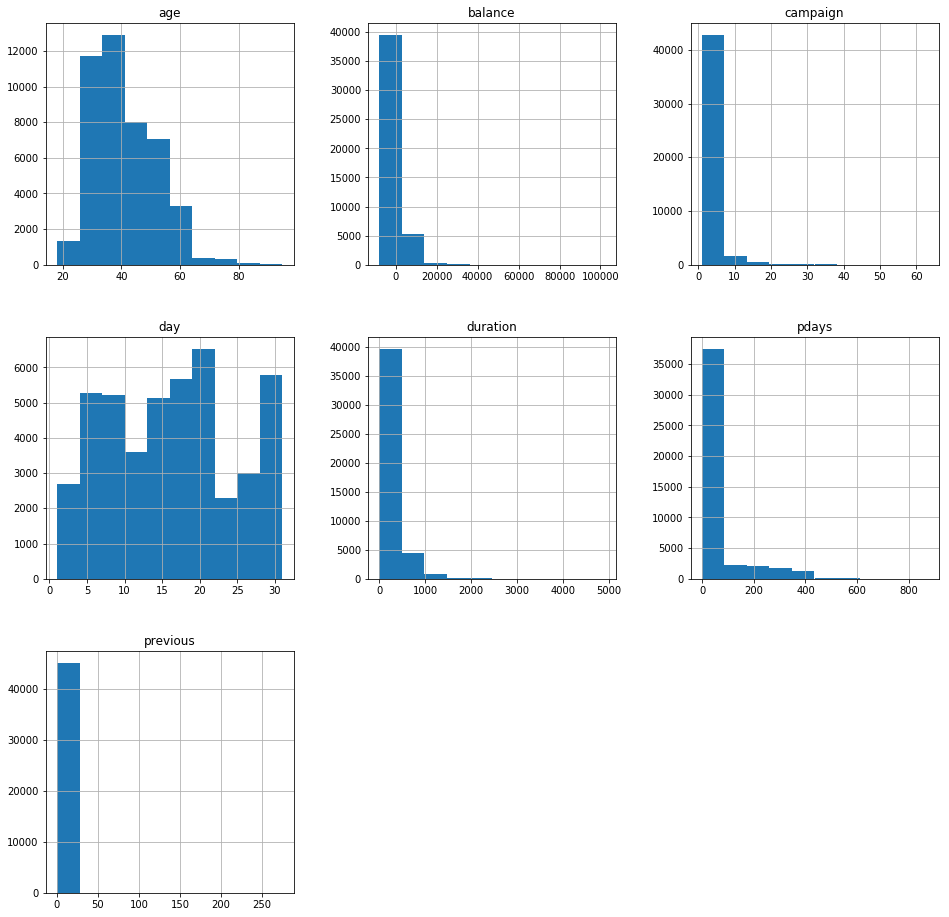

In [6]:
_ = dataset.hist(column=continuous_vars, figsize = (16,16))

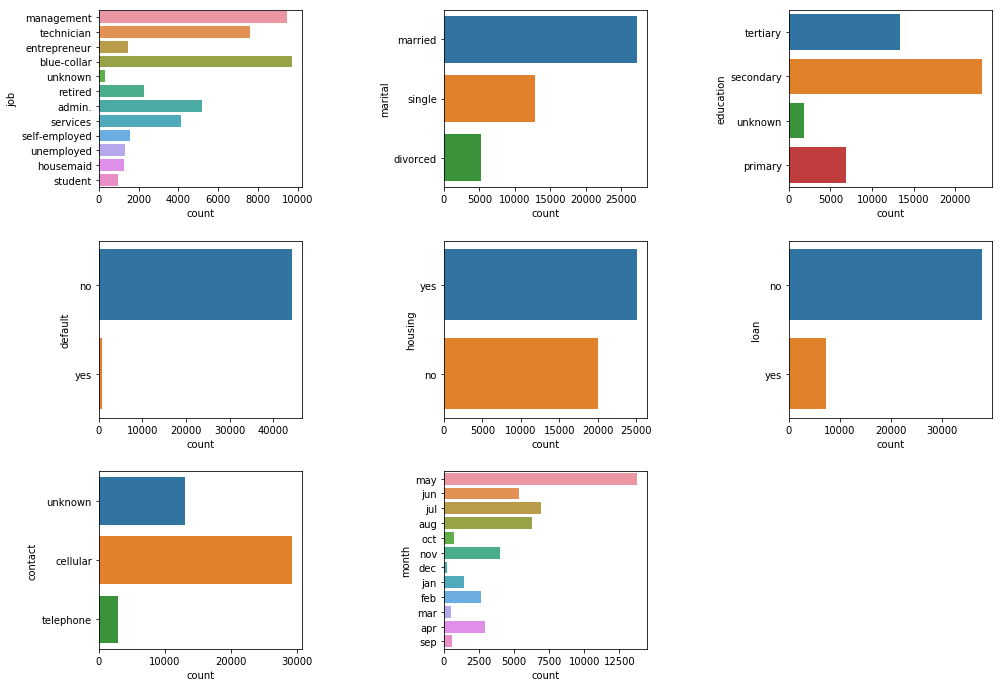

In [7]:
# Plotting count plot for categorical vars
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    if i > 7:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical_vars[i], data=dataset, ax=ax)

In [8]:
#check for any missing values#check  

dataset.apply(lambda x: sum(x.isnull()),axis=0)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

**** There are no any explicit missing values for any variable. If there were any then we would replaced those by either the mean or by the median(depends)

***Missing data in the data set can reduce the power / fit of a model or can lead to a biased model because we have not analysed the behavior and relationship with other variables correctly. It can lead to wrong prediction or classification.

In [9]:
# To check for Target variable distribution
count = dataset.groupby('y').size()
percent = count/len(dataset)*100
print(percent)

y
no     88.30152
yes    11.69848
dtype: float64


*****Distribution of #Target variable: "y": data is imbalanced because there is ~88% 'no' and 12% is 'yes'

In [10]:
# Lets see the descriptive stats of the dataset to figure out outlier treatment in the next steps.
dataset.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**** From the above result one can see that some variables ('balance','pdays', 'previous','Pdays','Duration') has outliers. That can also visualize through graphs further.

**** The Mean age is 41 here.
**** The mean balance is 1362 and the SD balance is high which is a sign that this is heavily distributed across the dataset

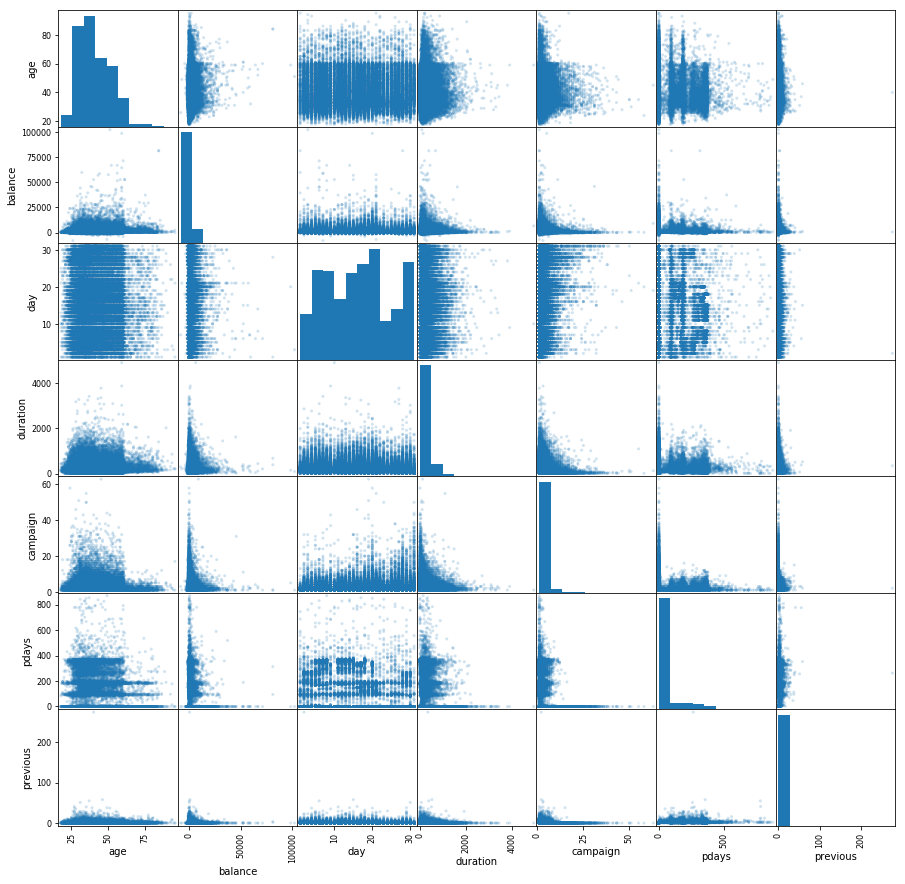

In [11]:
# Lets plot the scatter matrix here to check for relationship b/w the independent variables.
pd.plotting.scatter_matrix(dataset[continuous_vars], alpha=.2, figsize=(15, 15), cmap="viridis");


Scatter plot matrix showing that there is no strong relationship between continuous variables.No multicollinearity can be found among the variables.

As we have not got any relationship here, lets analyse all the continuous(independent) variables using the boxplot

# 2.1 Analysis for numerical variables
****Lets analyze all continuous Numerical variables against Target variable 'y' by plotting Boxplot.
Here we will see if we are getting outliers or not.

****Analysis of Indepedent Numerical Variables
Note:

1.To check for the presence of outliers.
Outliers can be defined as values out of range -1.5 x IQR to 1.5 x IQR but here I choose a range based on Maximum and Minimum value for each variable selected by observing Boxplot of corresponding variable.(It has been prepared down)

2.Post identification, Outlier values will be imputed by "mean" of respective variable by implementation of following "impute_outliers" function. Q1-First Quartile(25%), Q2-Second Quartile(75%), IQR-Inter Quartile Range

In [12]:
# Impute outliers function
def assign_outliers(df, column , minimum, maximum):
    col_values = df[column].values
    df[column] = np.where(np.logical_or(col_values<minimum, col_values>maximum), col_values.mean(), col_values)
    return df

In [41]:
# Q1 = dataset.quantile(0.25)
# Q3 = dataset.quantile(0.75)
# IQR = Q3 - Q1
# min_val = Q1-1.5*IQR
# max_val = Q3+1.5*IQR
# print(min_val)
# print(max_val)

age           10.500000
balance    -1863.408087
day          -11.500000
duration    -140.000000
campaign      -2.000000
pdays         -1.000000
previous       0.000000
dtype: float64
age           70.500000
balance     3297.680144
day           40.500000
duration     508.000000
campaign       6.000000
pdays         -1.000000
previous       0.000000
dtype: float64


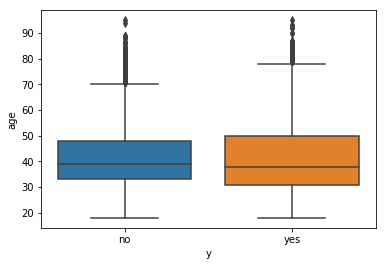

In [13]:
# age
sns.boxplot(x='y', y='age', data=dataset)

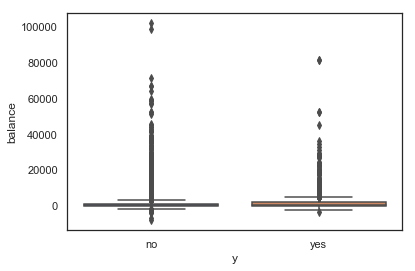

In [196]:
# Balance
sns.boxplot(x='y' , y='balance', data=dataset)

In [14]:
# Fixing balance column
dataset_new = dataset
min_val = dataset_new["balance"].min() 
max_val = 20000
dataset_new = assign_outliers(df=dataset_new, column='balance' , minimum=min_val, maximum=max_val)

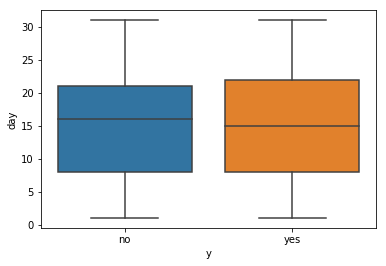

In [15]:
#Day
sns.boxplot(x='y', y='day', data=dataset)

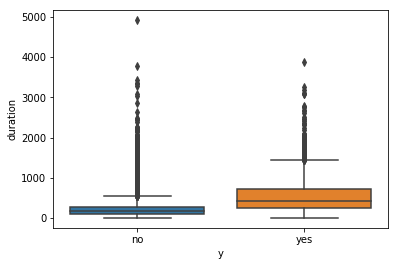

In [16]:
#Duration
sns.boxplot(x='y', y='duration', data=dataset)

In [17]:
# Fixing duration column# Fixing 
# min_val = -140
min_val = dataset_new["duration"].min()
# max_val = 643
max_val = 2000
dataset_new = assign_outliers(df=dataset_new, column='duration' , minimum=min_val, maximum=max_val)

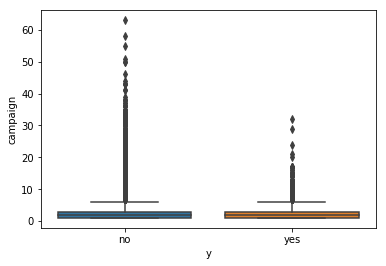

In [18]:
#Campaign
sns.boxplot(x='y', y='campaign', data=dataset)

In [19]:
# Fixing campaign column
# min_val = -2
min_val = dataset_new["campaign"].min()
max_val = 20
# max_val = 6
dataset_new = assign_outliers(df=dataset_new, column='campaign' , minimum=min_val, maximum=max_val)

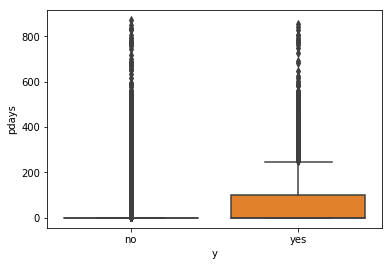

In [20]:
#pdays
sns.boxplot(x='y', y='pdays', data=dataset)

In [21]:
# Fixing pdays column
min_val = dataset_new["pdays"].min()
max_val = 250
dataset_new = assign_outliers(df=dataset_new, column='pdays' , minimum=min_val, maximum=max_val)

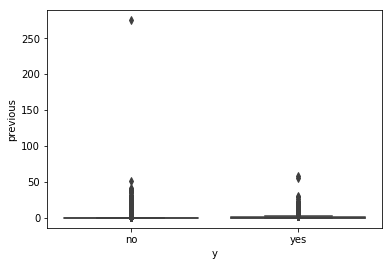

In [22]:
#previous
sns.boxplot(x='y', y='previous', data=dataset)

In [23]:
# Fixing 'previous' column
min_val = dataset_new["previous"].min()
max_val = 100
dataset_new = assign_outliers(df=dataset_new, column='previous' , minimum=min_val, maximum=max_val)

In [24]:
#lets see statistic of Numerical variables after Outlier treatment
dataset_new.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1239.089967,15.806419,255.154379,2.630474,17.370434,0.574254
std,10.618762,2213.867032,8.322476,242.792228,2.456852,47.938636,1.907906
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1397.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,19985.000000,31.000000,1994.000000,20.000000,250.000000,58.000000


Data now seems to be quite balanced as compared to the previous one

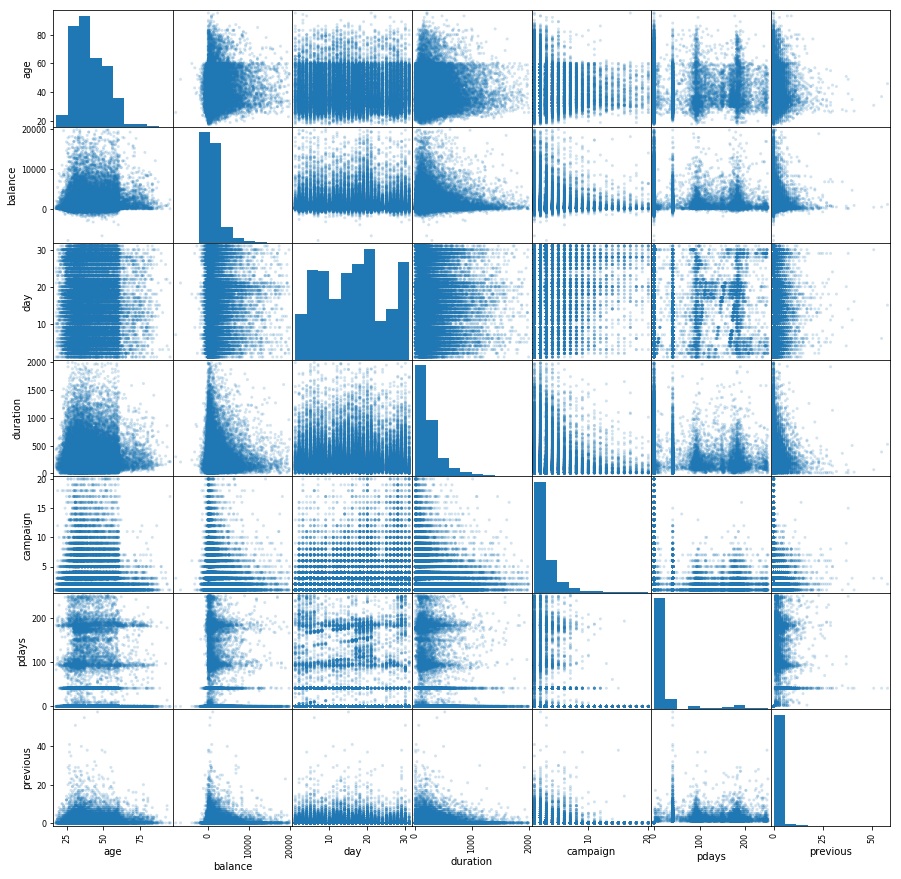

In [25]:
# Lets plot the scatter matrix here to check for relationship b/w the independent variables.
pd.plotting.scatter_matrix(dataset_new[continuous_vars], alpha=.2, figsize=(15, 15), cmap="viridis");

# 2.2 Analysis of Indepedent Categorical Variables
Note:
1. If any Categorical variable has more than 50% unknown values or seems highly unbalanced, the variable will be dropped.
2. If unknown values are less than 50% than we can replace them by Mode of respective variable by implementing following 'impute_unknowns' function.

In [26]:
# Impute unknowns function
def assign_unknowns(df, column):
    col_values = df[column].values
    df[column] = np.where(col_values=='unknown', dataset[column].mode(), col_values)
    return df

job
admin.           11.437482
blue-collar      21.525735
entrepreneur      3.289023
housemaid         2.742695
management       20.919688
retired           5.007631
self-employed     3.492513
services          9.188029
student           2.074716
technician       16.803433
unemployed        2.882042
unknown           0.637013
dtype: float64


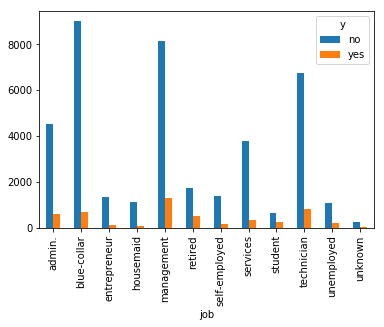

In [27]:
# job
temp1 = pd.crosstab(dataset['job'], dataset['y'])
temp1.plot(kind='bar')
print(dataset.groupby(['job']).size()/len(dataset)*100)

In [28]:
# Fixing 'job' column
dataset_new = assign_unknowns(df=dataset_new, column='job')

marital
divorced    11.517109
married     60.193316
single      28.289576
dtype: float64


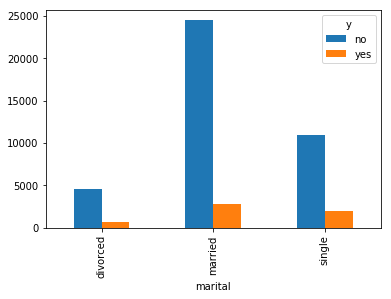

In [29]:
# marital
temp2 = pd.crosstab(dataset['marital'], dataset['y'])
temp2.plot(kind='bar')
print(dataset.groupby(['marital']).size()/len(dataset)*100)

education
primary      15.153392
secondary    51.319369
tertiary     29.419831
unknown       4.107407
dtype: float64


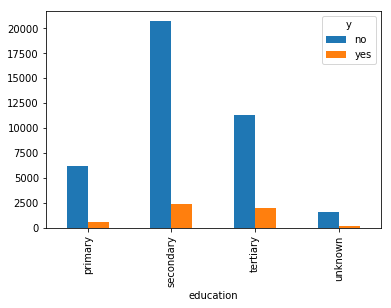

In [30]:
# education 
temp3 = pd.crosstab(dataset['education'], dataset['y'])
temp3.plot(kind='bar')
print(dataset.groupby(['education']).size()/len(dataset)*100)

In [31]:
# Fixing 'education' column# Fixing 
dataset_new = assign_unknowns(df=dataset_new, column='education')

default
no     98.197341
yes     1.802659
dtype: float64


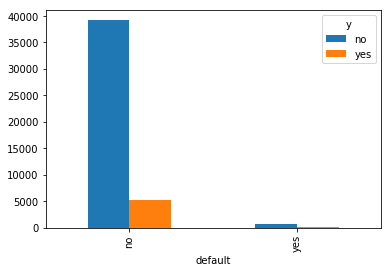

In [32]:
# default
temp4 = pd.crosstab(dataset['default'], dataset['y'])
temp4.plot(kind='bar')
print(dataset.groupby(['default']).size()/len(dataset)*100)

#This variable seems highly unbalanced (skewed) so we can drop this

In [33]:
#drop this variable.
del dataset_new['default']

housing
no     44.416182
yes    55.583818
dtype: float64


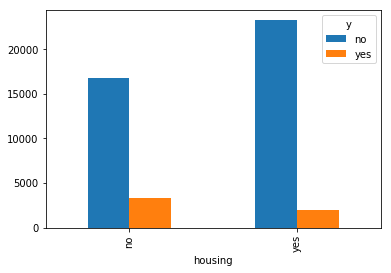

In [34]:
# housing
temp5 = pd.crosstab(dataset['housing'], dataset['y'])
temp5.plot(kind='bar')
print(dataset.groupby(['housing']).size()/len(dataset)*100)

contact
cellular     64.774059
telephone     6.427639
unknown      28.798301
dtype: float64


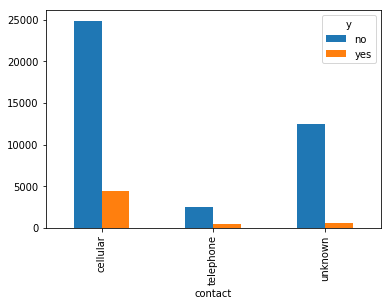

In [35]:
# "contact"
temp6 = pd.crosstab(dataset['contact'], dataset['y'])
temp6.plot(kind='bar')
print(dataset.groupby(['contact']).size()/len(dataset)*100)

In [36]:
# 'Contact' variable does not have any impact on target variable so we can drop this variable.
del dataset_new['contact']

month
apr     6.485147
aug    13.817434
dec     0.473336
feb     5.859194
jan     3.103227
jul    15.250713
jun    11.813497
mar     1.055053
may    30.448342
nov     8.781049
oct     1.632346
sep     1.280662
dtype: float64


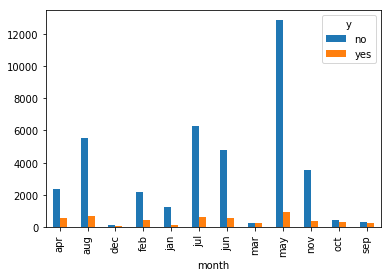

In [37]:
# "month"
temp7 = pd.crosstab(dataset['month'], dataset['y'])
temp7.plot(kind='bar')
print(dataset.groupby(['month']).size()/len(dataset)*100)

poutcome
failure    10.840282
other       4.069806
success     3.342107
unknown    81.747805
dtype: float64


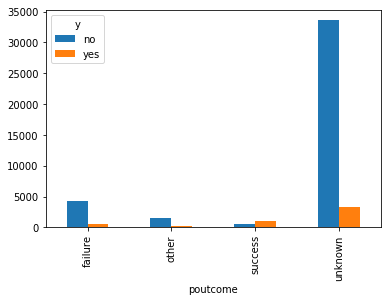

In [38]:
# "poutcome"
temp8 = pd.crosstab(dataset['poutcome'], dataset['y'])
temp8.plot(kind='bar')
print(dataset.groupby(['poutcome']).size()/len(dataset)*100)

In [39]:
#poutcome": more than 81% missing values of unknown type so we can drop this variable also.
#And Unknown is not one of them which is widely present in the dataset and adds no value to sample. It is not helpful to keep features which is highly unknown and whose affects cannot seen on dependent variable.
#dropping variable 'poutcome'

del dataset_new['poutcome']

In [40]:
dataset_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
balance      45211 non-null float64
housing      45211 non-null object
loan         45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null float64
campaign     45211 non-null float64
pdays        45211 non-null float64
previous     45211 non-null float64
y            45211 non-null object
dtypes: float64(5), int64(2), object(7)
memory usage: 4.8+ MB


In [41]:
dataset_new.head()

,age,job,marital,education,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,2143.0,yes,no,5,may,261.0,1.0,-1.0,0.0,no
1,44,technician,single,secondary,29.0,yes,no,5,may,151.0,1.0,-1.0,0.0,no
2,33,entrepreneur,married,secondary,2.0,yes,yes,5,may,76.0,1.0,-1.0,0.0,no
3,47,blue-collar,married,secondary,1506.0,yes,no,5,may,92.0,1.0,-1.0,0.0,no
4,33,blue-collar,single,secondary,1.0,no,no,5,may,198.0,1.0,-1.0,0.0,no


In [42]:
dataset_new.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1239.089967,15.806419,255.154379,2.630474,17.370434,0.574254
std,10.618762,2213.867032,8.322476,242.792228,2.456852,47.938636,1.907906
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1397.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,19985.000000,31.000000,1994.000000,20.000000,250.000000,58.000000


****For better plotting the key variables going forward,we will convert into integer columns that we think are vital to determine patterns. 

**** This Feature Engineering will also continue down when selecting the correct variables for the input model selection.

In [43]:
# Convert the columns that contain a Yes or No. (Binary Columns)
def convert_to_int(dataset_new, new_column, target_column):
    dataset_new[new_column] = dataset_new[target_column].apply(lambda x: 0 if x == 'no' else 1)
    return dataset_new[new_column].value_counts()

In [44]:
convert_to_int(dataset_new, "y_int", "y") #Create a deposit int
convert_to_int(dataset_new, "housing_int", "housing") # Create housingint column
convert_to_int(dataset_new, "loan_int", "loan") #Create a loan_int column

0    37967
1     7244
Name: loan_int, dtype: int64

In [45]:
# Drop the binary columns and leave the same column in the form of integers 0 = No and 1 = Yes
dataset_new.drop(['housing', 'loan'], axis=1, inplace=True)

In [46]:
# We have the amount of targeted potential clients in each of the different months of the year.
# The cross_month var. simply states the (%) of how many p.clients accepted or refused a suscription to a term deposit.
print(dataset_new['month'].value_counts())
cross_month = pd.crosstab(dataset_new['month'], dataset_new['y']).apply(lambda x: x/x.sum() * 100)
cross_month

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64


y,no,yes
month,,
apr,5.899003,10.909435
aug,13.924653,13.008130
dec,0.285557,1.890717
feb,5.530785,8.338060
jan,3.158659,2.684818
jul,15.700616,11.854793
jun,12.010921,10.323313
mar,0.573619,4.688977
may,32.165222,17.489128


In [47]:
# Create a column with the numeric values of the months.
dataset_new['year'] = 2018
lst = [dataset_new]

for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

# Change datatype from int32 to int64
dataset_new["month_int"] = dataset_new["month_int"].astype(np.int64)

In [48]:
dataset_new.drop(['day','year', 'y'], axis=1, inplace=True)

In [49]:
dataset_new = dataset_new.rename(columns={"y_int": "y"})

In [50]:
first = dataset_new['y']
dataset_new.drop(labels=['y'], axis=1,inplace = True)
# insert (loc, column, values) --> loc is the same as position in the column.
dataset_new.insert(0, 'y', first)
dataset_new["y"].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [51]:
# convert the duration from Seconds to Minutes and then making it as categorical feature.
decimal_points = 2
dataset_new['duration'] = dataset_new['duration'] / 60
dataset_new['duration'] = dataset_new['duration'].apply(lambda x: round(x, decimal_points))
dataset_new.head()

,y,age,job,marital,education,balance,month,duration,campaign,pdays,previous,housing_int,loan_int,month_int
0,0,58,management,married,tertiary,2143.0,may,4.35,1.0,-1.0,0.0,1,0,5
1,0,44,technician,single,secondary,29.0,may,2.52,1.0,-1.0,0.0,1,0,5
2,0,33,entrepreneur,married,secondary,2.0,may,1.27,1.0,-1.0,0.0,1,1,5
3,0,47,blue-collar,married,secondary,1506.0,may,1.53,1.0,-1.0,0.0,1,0,5
4,0,33,blue-collar,single,secondary,1.0,may,3.30,1.0,-1.0,0.0,0,0,5


In [52]:
dataset_new.describe()

,y,age,balance,duration,campaign,pdays,previous,housing_int,loan_int,month_int
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.116985,40.936210,1239.089967,4.252581,2.630474,17.370434,0.574254,0.555838,0.160226,6.144655
std,0.321406,10.618762,2213.867032,4.046544,2.456852,47.938636,1.907906,0.496878,0.366820,2.408034
min,0.000000,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,33.000000,72.000000,1.720000,1.000000,-1.000000,0.000000,0.000000,0.000000,5.000000
50%,0.000000,39.000000,448.000000,3.000000,2.000000,-1.000000,0.000000,1.000000,0.000000,6.000000
75%,0.000000,48.000000,1397.000000,5.300000,3.000000,-1.000000,0.000000,1.000000,0.000000,8.000000
max,1.000000,95.000000,19985.000000,33.230000,20.000000,250.000000,58.000000,1.000000,1.000000,12.000000


# 3. Exploratory Data Analysis 

What percentage(%) of potential clients accepted to suscribe to term deposits vs refused to suscribe term deposits.
TO check if there is a huge difference between clients that suscribed term deposits vs refused deposits?

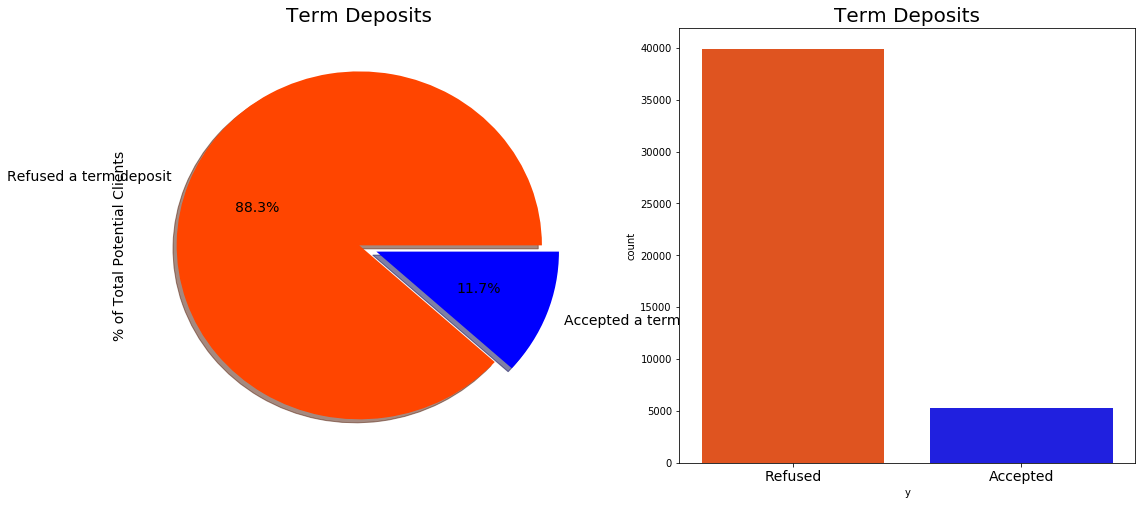

In [53]:
f,ax=plt.subplots(1,2,figsize=(18,8))
colors=["#FF4500", "#0000FF"]
labels = 'Refused a term deposit', 'Accepted a term deposit'
dataset_new['y'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, colors=colors, labels=labels,fontsize=14)
ax[0].set_title('Term Deposits', fontsize=20)
ax[0].set_ylabel('% of Total Potential Clients', fontsize=14)
sns.countplot('y',data=dataset_new,ax=ax[1], palette=colors)
ax[1].set_title('Term Deposits', fontsize=20)
ax[1].set_xticklabels(['Refused', 'Accepted'], fontsize=14)
plt.show()

# Observation:
88.3% refused to term deposits while 11.7% accepted to term deposits.

# Going Forward we will now check critical parameters basis the values provided in the data set if the bank will give customer the term deposit or not.
For the potential customer / client ,the analysis will include some special conisderations like 
1. Age
2. Month / Season of the marketing activity
3. Occupation / Job
-- A general correlation matrix to establish some close knit relations
4. Balance Categories Vs Housing Loans and their effect.
5. Negative relationship between Loans and Suscriptions of Term Deposits
6. Calls made to the potential customer / client and their impact

# A General plot of some of the key metrics mentioned above.

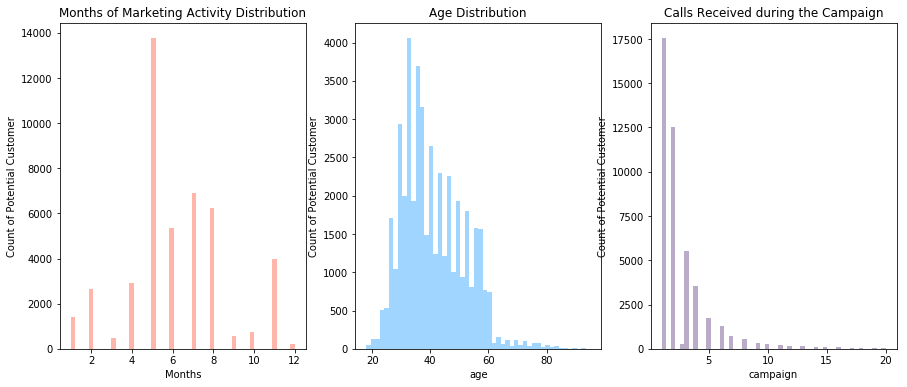

In [54]:
import seaborn as sns

f, axes = plt.subplots(ncols=3, figsize=(15, 6))

# Graph Employee Satisfaction
sns.distplot(dataset_new['month_int'], kde=False, color="#ff4729", ax=axes[0]).set_title('Months of Marketing Activity Distribution')
axes[0].set_ylabel('Count of Potential Customer')
axes[0].set_xlabel('Months')

# Graph Employee Evaluation
sns.distplot(dataset_new['age'], kde=False, color="#1297ff", ax=axes[1]).set_title('Age Distribution')
axes[1].set_ylabel('Count of Potential Customer')

# Campaigns
sns.distplot(dataset_new['campaign'], kde=False, color="#532E7A", ax=axes[2]).set_title('Calls Received during the Campaign')
axes[2].set_ylabel('Count of Potential Customer')

plt.show()

In [ ]:
# from the above we can see that the highest marketing month turned out to be the month of May and Dec being the lowest.
# we have already established this relation earlier as well but plotting gives a clear picture. 

# Analysis-Age of Potential Clients:
Creating age buckets so that we can have a comprehensive view.
This process will be the most effective one as Demographic info like age bucket will have a huge impact on the model outcome.

Text(0.5,1,'Frequency of Distribution of Deposits by Age')

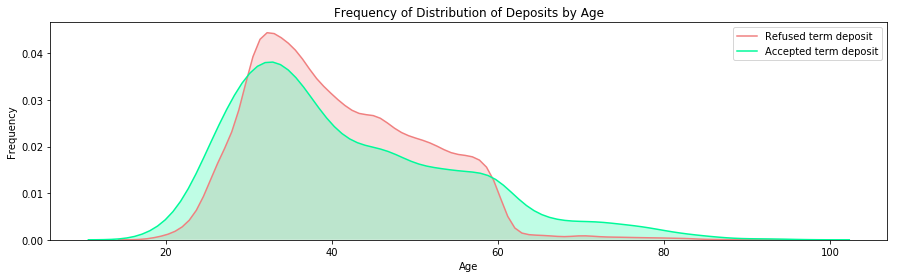

In [55]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(dataset_new.loc[(dataset_new['y'] == 0),'age'] , color='#F08080',shade=True,label='Refused term deposit')
ax=sns.kdeplot(dataset_new.loc[(dataset_new['y'] == 1),'age'] , color='#00FA9A',shade=True, label='Accepted term deposit')
ax.set(xlabel='Age', ylabel='Frequency')
plt.title('Frequency of Distribution of Deposits by Age')

In [56]:
# This is to create each of the categories.
lst = [dataset_new]
for column in lst:
    column.loc[column["age"] < 30,  "age_category"] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), "age_category"] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), "age_category"] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), "age_category"] = 50
    column.loc[column["age"] >= 60, "age_category"] = 60
 
dataset_new['age_category'] = dataset_new['age_category'].astype(np.int64)
dataset_new.dtypes

y                 int64
age               int64
job              object
marital          object
education        object
balance         float64
month            object
duration        float64
campaign        float64
pdays           float64
previous        float64
housing_int       int64
loan_int          int64
month_int         int64
age_category      int64
dtype: object

In [57]:
# Liklehood that each age bucket could get a term deposit.
cross_age_category = pd.crosstab(dataset_new['y'], dataset_new['age_category']).apply(lambda x: x/x.sum() * 100)
cross_age_category

age_category,20,30,40,50,60
y,,,,,
0,82.40091,89.424512,90.879451,90.665874,66.367713
1,17.59909,10.575488,9.120549,9.334126,33.632287


In [58]:
# Number of potential clients in each age category.
dataset_new["age_category"].value_counts()

30    18089
40    11655
50     8410
20     5273
60     1784
Name: age_category, dtype: int64

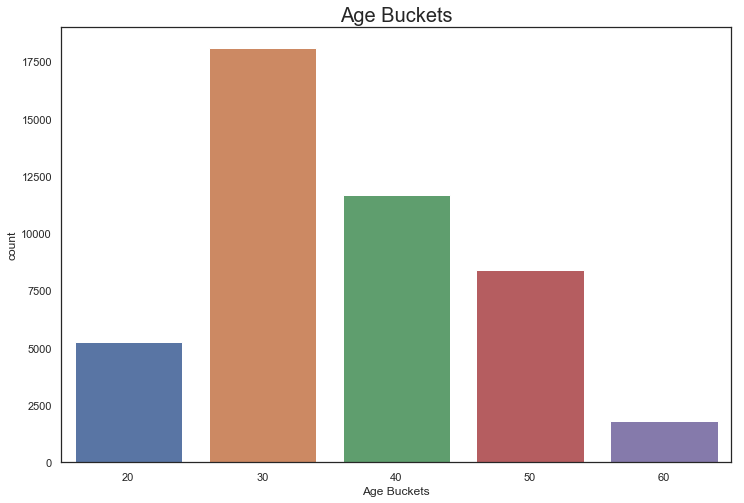

In [59]:
import seaborn as sns
sns.set(style="white")
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x="age_category", data=dataset_new)
ax.set_title("Age Buckets", fontsize=20)
ax.set_xlabel("Age Buckets")
plt.show()

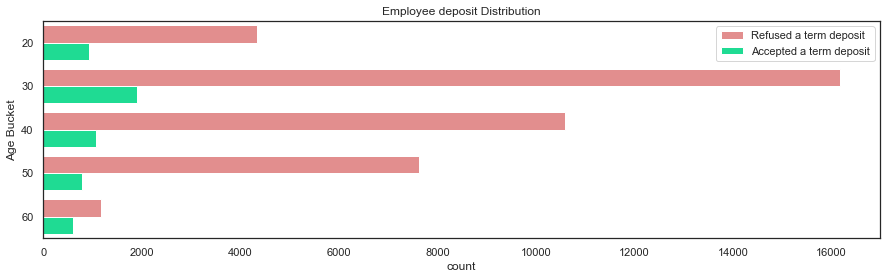

In [60]:
# There was a positive ratio of Suscribing Term Deposits  of people in their 20s (or younger) and 60s (or older)
sns.set(style="white")
fig, ax = plt.subplots(figsize=(15, 4))
colors = ["#F08080", "#00FA9A"]
labels = ['No Deposit', 'Deposit']
sns.countplot(y="age_category", hue='y', data=dataset_new, palette=colors).set_title('Employee deposit Distribution')
ax.set_ylabel("Age Bucket")
legend_name = plt.legend()
legend_name.get_texts()[0].set_text('Refused a term deposit')
legend_name.get_texts()[1].set_text('Accepted a term deposit')

# Observation by Age Analysis:
Most of the potential clients the bank targeted have 30-40 years old.
20s and younger: Around 18% of potential clients in this category subscribed to term deposit.
30s - 50s: Around 10% of the potential clients in this category subscribed to term deposits accounts.
60s and older: Around 34% subscribed term deposits!
The youngest and eldest population segments were the most likely to open a term deposit account.

# Analysis-Monthly Campaign activity
I will startby creating a crosstab across the months to see the deposit activities per month

In [61]:
months_example = pd.crosstab(index=dataset_new['y'],
                            columns=dataset_new['month_int'],
                            margins=True)

# Gives the percent of suscribed term deposits
(months_example/months_example.loc['All']) * 100


month_int,1,2,3,4,5,6,7,8,9,10,11,12,All
y,,,,,,,,,,,,,
0,89.878831,83.352208,48.008386,80.3206,93.280546,89.777195,90.906454,88.986714,53.540587,56.233062,89.848866,53.271028,88.30152
1,10.121169,16.647792,51.991614,19.6794,6.719454,10.222805,9.093546,11.013286,46.459413,43.766938,10.151134,46.728972,11.69848
All,100.000000,100.000000,100.000000,100.0000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000


y                 0         1
month_int                    
1          0.027891  0.003141
2          0.048838  0.009754
3          0.005065  0.005485
4          0.052089  0.012762
5          0.284024  0.020460
6          0.106058  0.012077
7          0.138639  0.013868
8          0.122957  0.015218
9          0.006857  0.005950
10         0.009179  0.007144
11         0.078897  0.008914
12         0.002522  0.002212


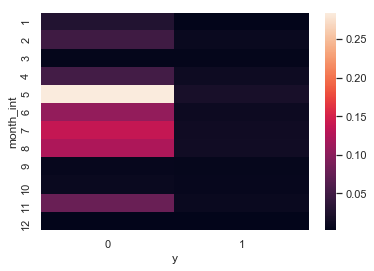

In [62]:
frequencies = pd.crosstab( dataset_new[ "month_int"], dataset_new[ "y"]).apply(lambda r: r/len(dataset_new))
print(frequencies)
sns.heatmap(frequencies)

****Month of May, Jun, July, August & November have negative impact on the output

In [63]:
cross_months = pd.crosstab(dataset_new['y'], dataset_new['month_int'])
print(cross_months)
nodeposit_rate = pd.DataFrame(cross_months.iloc[0])
deposit_rate = pd.DataFrame(cross_months.iloc[1])
nodeposit_rate = nodeposit_rate.values.tolist()
deposit_rate = deposit_rate.values.tolist()
print(deposit_rate[0])

month_int    1     2    3     4      5     6     7     8    9    10    11   12
y                                                                             
0          1261  2208  229  2355  12841  4795  6268  5559  310  415  3567  114
1           142   441  248   577    925   546   627   688  269  323   403  100
[142]


Text(0.5,1,'Distribution of Deposits by Month')

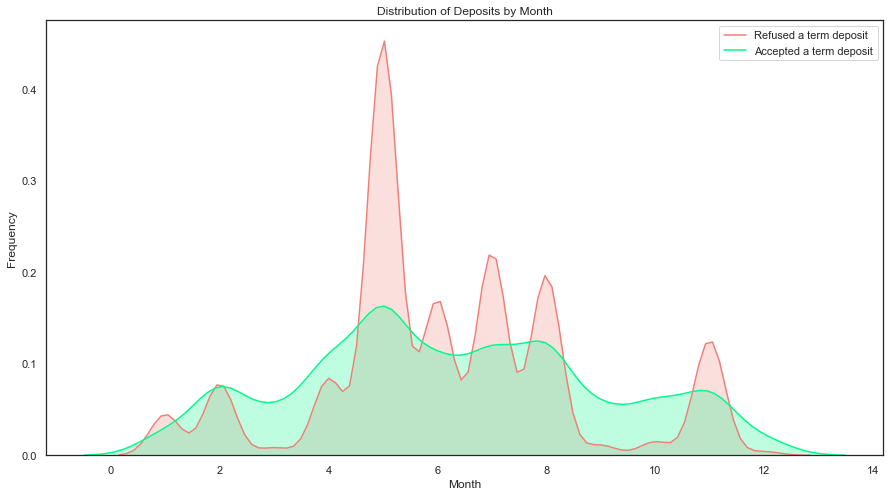

In [64]:
fig = plt.figure(figsize=(15,8),)
ax=sns.kdeplot(dataset_new.loc[(dataset_new['y'] == 0),'month_int'] , color='#F08077',shade=True,label='Refused a term deposit')
ax=sns.kdeplot(dataset_new.loc[(dataset_new['y'] == 1),'month_int'] , color='#00FA8B',shade=True, label='Accepted a term deposit')
ax.set(xlabel='Month', ylabel='Frequency')
plt.title('Distribution of Deposits by Month')

# Lets also analyse the data by the seasons:
By grouping the months into 4 different seasons in an year.

In [65]:
# Create the Season column.
dataset_new['season'] = np.nan
lst=[dataset_new]
# The conditions for determining each of the seasons.
for column in lst:
    column.loc[(column["month_int"] >= 3) & (column["month_int"] <= 5), 'season'] = 'spring'
    column.loc[(column["month_int"] >= 6) & (column["month_int"] <= 8), 'season'] = 'summer'
    column.loc[(column["month_int"] >= 9) & (column["month_int"] <= 11), 'season'] = 'fall'
    column.loc[column["month_int"] <= 2, 'season'] = 'winter'
    column.loc[column["month_int"] == 12, 'season'] = 'winter'
    
dataset_new['season'].value_counts()

summer    18483
spring    17175
fall       5287
winter     4266
Name: season, dtype: int64

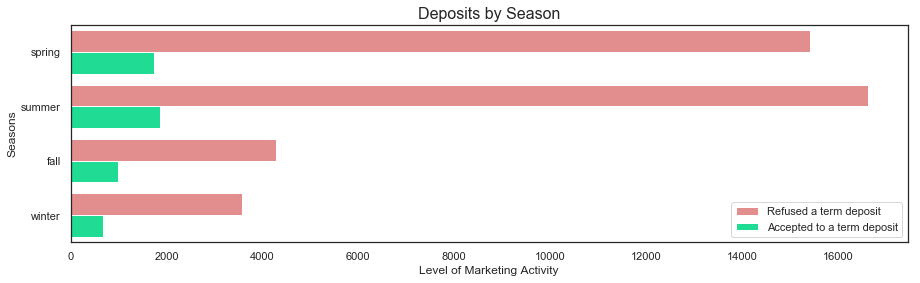

In [66]:
# check the deposit data basis the new seasons variable that we have created

fig = plt.figure(figsize=(15,4),)

colors = ['#F08080', '#00FA9A']

ax = sns.countplot(y='season', data=dataset_new,
           hue='y',
           palette = colors
          ) 
plt.title("Deposits by Season", fontsize=16)
plt.ylabel("Seasons", fontsize=12)
plt.xlabel("Level of Marketing Activity", fontsize=12)
legend_name = plt.legend()
legend_name.get_texts()[0].set_text('Refused a term deposit')
legend_name.get_texts()[1].set_text('Accepted to a term deposit')
plt.show()

# Observation regarding Months( Along with Season Bucketing) analysis:
a. There is a wide gap during the month of May between rejected and accepted term deposit subscriptions.
b. The Marketing team of the bank looks like they have focused their efforts to make people subscribe term deposits accounts during the seasons of spring and summer.
c. Month of May, Jun, July, August & November have negative impact on the output

# Analysis- Occupation/Job type and the effect on term deposit subscription.

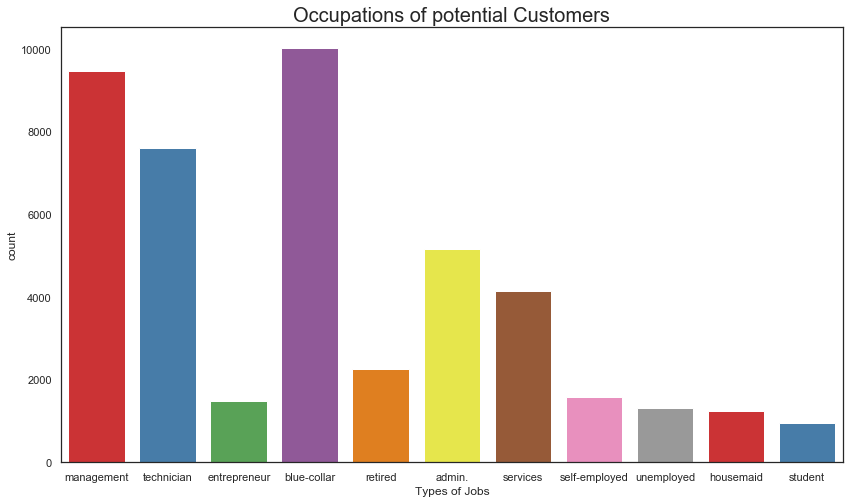

In [67]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(14,8))
sns.countplot(x="job", data=dataset_new, palette="Set1")
ax.set_title("Occupations of potential Customers", fontsize=20)
ax.set_xlabel("Types of Jobs")
plt.show()

In [68]:
# Creating a cross tab to see how the data looks like for the variable y vs Jobs
cross_job_category = pd.crosstab(dataset_new['y'], dataset_new['job']).apply(lambda x: x/x.sum() * 100)
print(cross_job_category)

nodeposit_by_job = pd.DataFrame(cross_job_category.iloc[0])
nodeposit_by_job = np.around(nodeposit_by_job, 1)
nodeposit_by_job = nodeposit_by_job.values.tolist()
deposit_by_job = pd.DataFrame(cross_job_category.iloc[1])
deposit_by_job = np.around(deposit_by_job, 1)
deposit_by_job = deposit_by_job.values.tolist()
#print the ones which had a job and then got the offer
deposit_by_job

job     admin.  blue-collar  entrepreneur  housemaid  management    retired  \
y                                                                             
0    87.797331     92.59481     91.728312  91.209677   86.244449  77.208481   
1    12.202669      7.40519      8.271688   8.790323   13.755551  22.791519   

job  self-employed   services    student  technician  unemployed  
y                                                                 
0        88.157061  91.116996  71.321962   88.943004   84.497314  
1        11.842939   8.883004  28.678038   11.056996   15.502686  


[[12.2],
 [7.4],
 [8.3],
 [8.8],
 [13.8],
 [22.8],
 [11.8],
 [8.9],
 [28.7],
 [11.1],
 [15.5]]

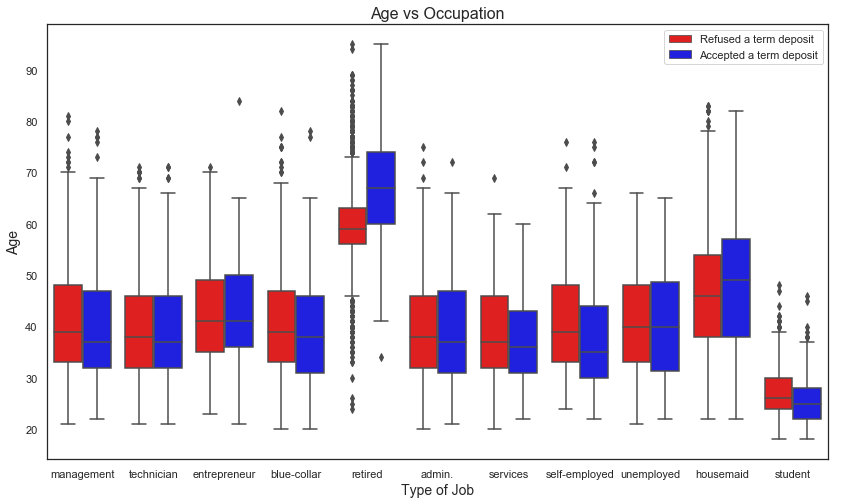

In [71]:
import seaborn as sns
ax = plt.figure(figsize=(14,8))
# 0 = Did not suscribe term deposits, 1 = Did suscribe term deposits.
ax = sns.boxplot(x="job", y="age", hue="y",
                  data=dataset_new, palette={0:'#FF0000', 1:'#0000FF'})
plt.title("Age vs Occupation", fontsize=16)
plt.xlabel(s="Type of Job", fontsize=14)
plt.ylabel(s="Age", fontsize=14)
legend_name = plt.legend()
legend_name.get_texts()[0].set_text('Refused a term deposit')
legend_name.get_texts()[1].set_text('Accepted a term deposit')

plt.show()

# Observation regarding Job Analysis:
a.People who are retired, are students or are unemployed received the most offers from the marketing department for term deposits.
b.Blue Collar, entrepreneurs and housemaids received the least amount of offers from the marketing department.
C.The potential clients who belong to the retired category and refused to suscribe a term deposit were much younger (median age: Around 62) than the potential clients who accepted to suscribe a term deposit (median age: Around 69).


# Checking for the Correlation- An important step

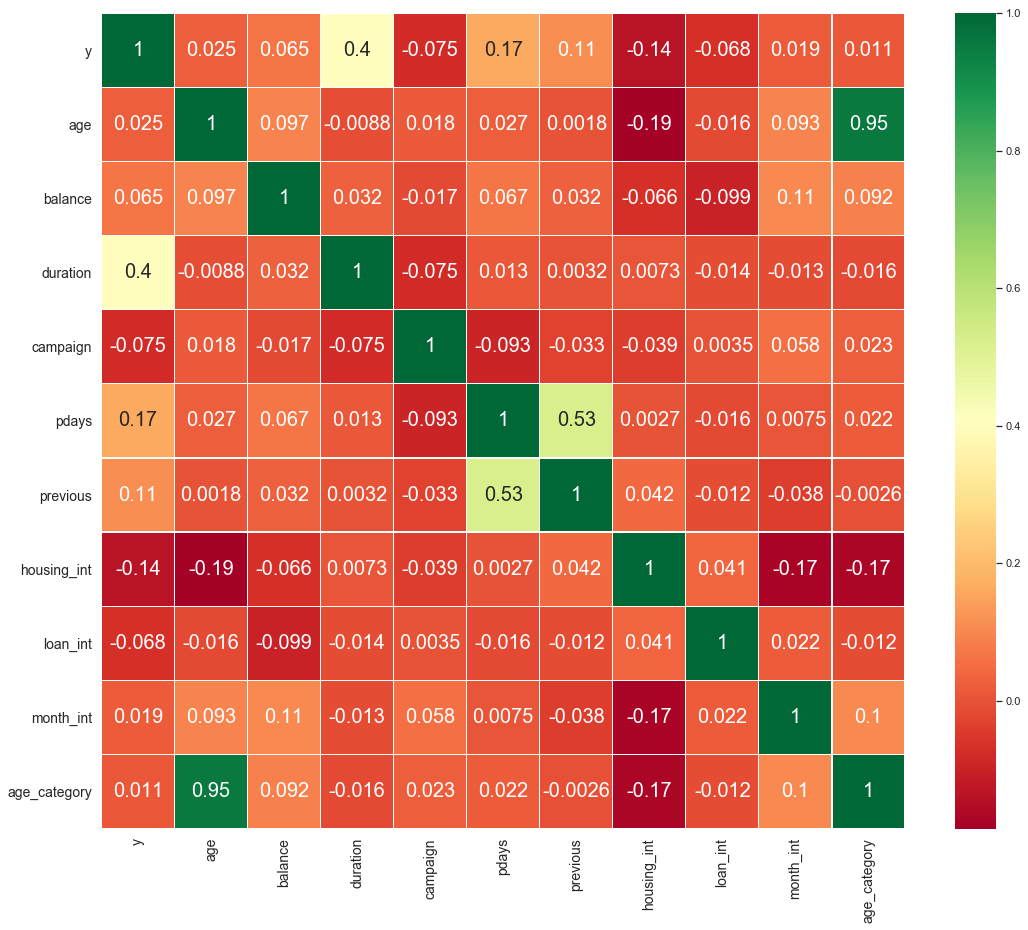

In [72]:
corr = dataset_new.corr()
sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Observation regarding Correlation matrix:

1.The more green the square is, the more positive correlated it is with the column. The more red the square is, the more negative correlated the columns are.

2.One of the positive correlation that I find interesting to analyze in our correlation matrix is the balance of potential clients. Balance has a 0.065 (6.5%) positive correlation in whether a potential clients will suscribe a term deposit

# Analyse data by Balance Categories Vs Housing Loans ,Another very important aspect that can act as a diffrentiator here:

Let us create some balance categories here that will help us demystifying the data better.

a) No Balance: This category will be the potential clients who do not have a balance or have a negative balance. This potential clients should not be that much of an interest to the bank, since at the end the banks are also looking for people who have balance in their accounts for investment reasons. 

b) Low Balance: Potential clients will have a balance greater than 0 but lower than 1,000.

c) Average Balance: Potential clients will have a balance greater than 1,000 but lower than 5,000

d) High Balance: Potential clients will have a balance greater than 5,000.



In [73]:
dataset_new['balance_categories'] = np.nan

lst = [dataset_new]

for column in lst:
    column.loc[column['balance'] <= 0, 'balance_categories'] = 'no balance'
    column.loc[(column['balance'] > 0) & (column['balance'] <= 1000), 'balance_categories'] = 'low balance'
    column.loc[(column['balance'] > 1000) & (column['balance'] <= 5000), 'balance_categories'] = 'average balance'
    column.loc[column['balance'] > 5000, 'balance_categories'] = 'high balance'
    
dataset_new.head()
dataset_new['balance_categories'].value_counts()
# We are targeting by a lot people with low balance!

low balance        23300
average balance    11979
no balance          7280
high balance        2652
Name: balance_categories, dtype: int64

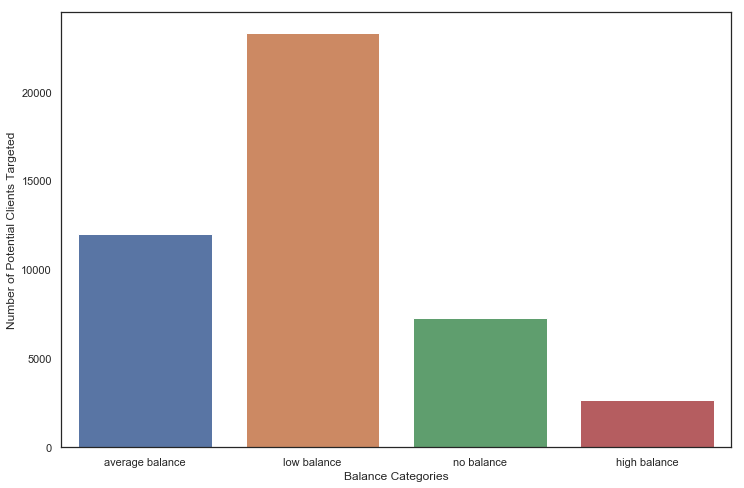

In [74]:
fig, ax = plt.subplots(figsize=(12,8))
g = sns.countplot(x="balance_categories", data=dataset_new)

#plt.title("Target Request per Balance Categories")
plt.xlabel('Balance Categories')
plt.ylabel("Number of Potential Clients Targeted")
plt.show()

In [75]:
balance_category = pd.crosstab(dataset_new['y'], dataset_new['balance_categories']).apply(lambda x: x/x.sum() * 100)
balance_category

balance_categories,average balance,high balance,low balance,no balance
y,,,,
0,84.673178,84.464555,89.103004,93.104396
1,15.326822,15.535445,10.896996,6.895604


In [76]:
# this will also follow in the next section of analysis which I have prepared.
balance_category = pd.crosstab(dataset_new['housing_int'], dataset_new['balance_categories']).apply(lambda x: x/x.sum() * 100)
balance_category

balance_categories,average balance,high balance,low balance,no balance
housing_int,,,,
0,48.267802,52.60181,43.004292,39.615385
1,51.732198,47.39819,56.995708,60.384615


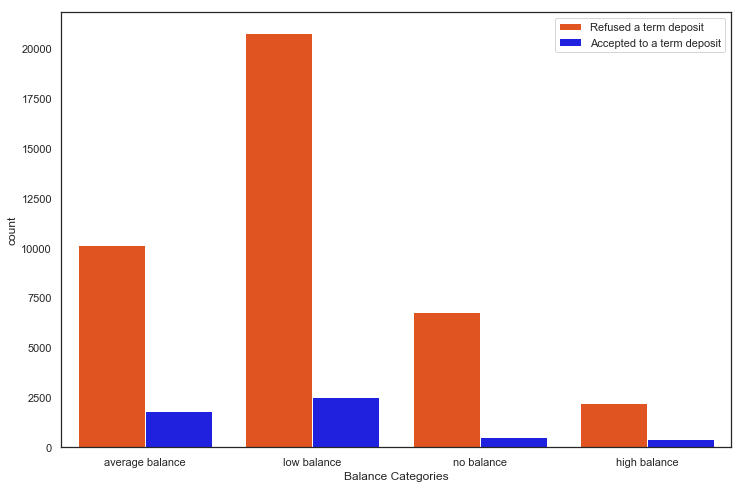

In [77]:
fig, ax = plt.subplots(figsize=(12,8))
g = sns.countplot(x="balance_categories", data=dataset_new, hue='y', palette={0:'#FF4500', 1:'#0000FF'})
legend_name = plt.legend()
legend_name.get_texts()[0].set_text('Refused a term deposit')
legend_name.get_texts()[1].set_text('Accepted to a term deposit')
plt.xlabel('Balance Categories')
plt.show()

# Observation regarding housing loan vs average balances vs age categories:
   
a. The marketing campaign is targeting excessively potential clients from the low balance segment. Low balance could lead to a probability that the customer/ client will refuse to subscribe to a term deposit.
b. The marketing campaign targets fewer people who have an average balance and high balance. The campaign has targeted higher number of people in the low balance or no balance categories.
c. People with no balance and low balance were more likely to have a house loan.

# Negative relationship between Loans and Subscriptions of Term Deposits

In [78]:
# Apparently having a house loan was a huge reason for not suscribing a term deposit.
cross_house = pd.crosstab(dataset_new['y'], dataset_new['housing_int']).apply(lambda x: x/x.sum() * 100)
print(cross_house)
nodeposits = cross_house.iloc[0]
nodeposits = np.around(nodeposits, 2)
nodeposits = nodeposits.values.tolist()
deposits = cross_house.iloc[1]
deposits = np.around(deposits, 2)
deposits = deposits.values.tolist()
deposits

housing_int          0         1
y                               
0            83.297645  92.30004
1            16.702355   7.69996


[16.7, 7.7]

In [79]:
# People with no balance and low balance have a higher probability of having a house loan which in return will lead 
# to potential clients that refused suscribing term deposits.
cross_house = pd.crosstab(dataset_new["housing_int"], dataset_new["balance_categories"]).apply(lambda x: x/x.sum() * 100)
cross_house

balance_categories,average balance,high balance,low balance,no balance
housing_int,,,,
0,48.267802,52.60181,43.004292,39.615385
1,51.732198,47.39819,56.995708,60.384615


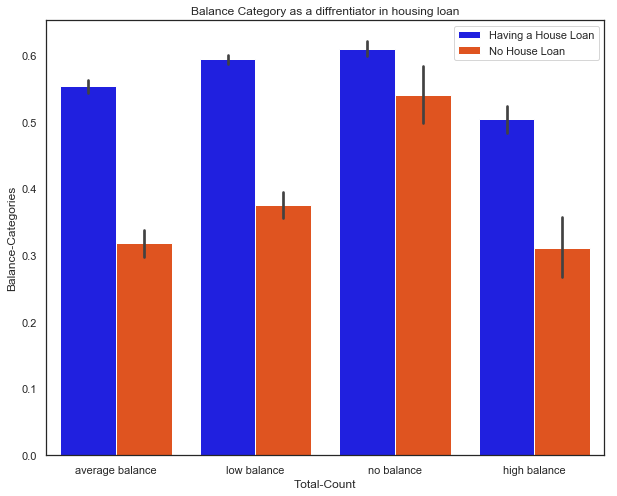

In [80]:
fig, ax = plt.subplots(figsize=(10,8))
colors = ["#0000FF", "#FF4500"]
ax = sns.barplot(x='balance_categories', y='housing_int', data=dataset_new, hue="y", palette=colors)
ax.set_title("Balance Category as a diffrentiator in housing loan")
ax.set_xlabel('Total-Count')
ax.set_ylabel('Balance-Categories')
legend_name = plt.legend()
legend_name.get_texts()[0].set_text('Having a House Loan')
legend_name.get_texts()[1].set_text('No House Loan')
plt.show()

# Observation regarding Negative Relationship
a.Potential clients that had a housing loan were more eager to refuse offers to subscribe a term deposit in the bank,
b.In this case People with no balance and low balance have a higher probability of having a house loan which in return will lead to potential clients that refused subscribing term deposits.

# Number of Calls in this Campaign

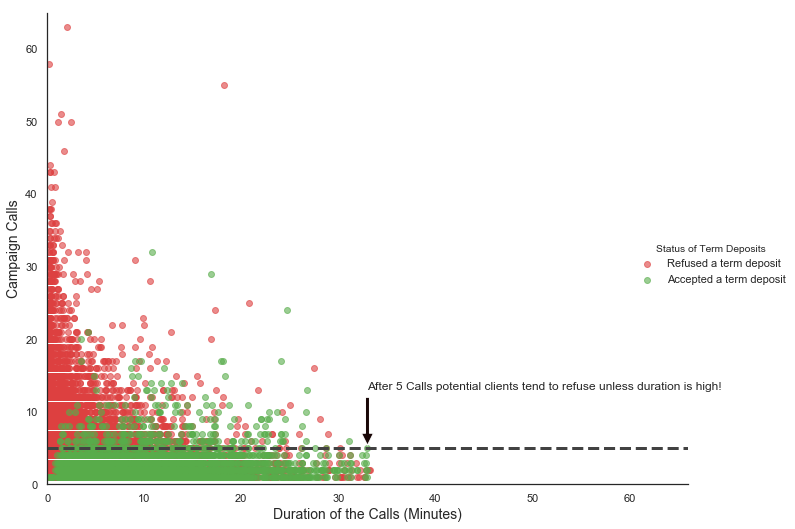

In [161]:
# checking campiagn calls with the duration
colors = ['#DD4040', '#58AD4B', '#0096AA', '#9B00AA']

g = sns.lmplot(x='duration', y='campaign', data=dataset_new,
           fit_reg=False, # No regression line
           hue='y',
        palette = colors,
        scatter_kws={'alpha':0.6}
          ) 

g.fig.set_size_inches(12,8)
# title
new_title = 'Status of Term Deposits'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Refused a term deposit', 'Accepted a term deposit']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.axis([0,66,0,65])
plt.axhline(y=5, linewidth=3, color="#424242", linestyle='--')
plt.annotate('After 5 Calls potential clients tend to refuse unless duration is high!', xy=(33, 5), xytext=(33,13),
            arrowprops=dict(facecolor='#190707', shrink=0.05))
plt.xlabel('Duration of the Calls (Minutes)', fontsize=14)
plt.ylabel('Campaign Calls', fontsize=14)
plt.show()

In [81]:
dataset_new['call_duration_categories'] = np.nan

lst = [dataset_new]

for column in lst:
    column.loc[(column['duration'] >= 0) & (column['duration'] < 2), 'call_duration_categories'] = 'Short Length Call'
    column.loc[(column['duration'] >= 2) & (column['duration'] < 10), 'call_duration_categories'] = 'average length Call'
    column.loc[column['duration'] > 10, 'call_duration_categories'] = 'Lengthy Calls'
    
dataset_new.head()
dataset_new['call_duration_categories'].value_counts()

average length Call    27560
Short Length Call      13908
Lengthy Calls           3731
Name: call_duration_categories, dtype: int64

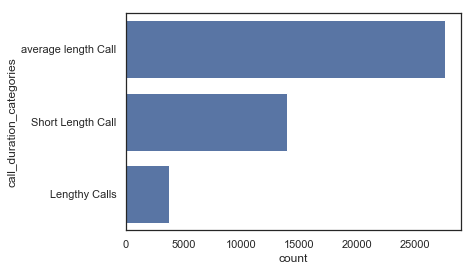

In [82]:
sns.countplot(y="call_duration_categories", data=dataset_new, color="C0");

In [83]:
cross_call_length = pd.crosstab(dataset_new["y"], dataset_new["call_duration_categories"]).apply(lambda x: x/x.sum() * 100)
cross_call_length

call_duration_categories,Lengthy Calls,Short Length Call,average length Call
y,,,
0,51.675154,98.533218,88.105951
1,48.324846,1.466782,11.894049


In [ ]:
# #Lets Analyse here what we left in cell 41
# # Cross tab to check the target variable 'y' with the duration category we created along with the type of contct medium

# dur_cont_type  = pd.crosstab(index=dataset_new["y"], 
#                              columns=[dataset_new["contact"],
#                                       dataset_new["call_duration_categories"]])
                             
# #                              margins=True)
                            

# dur_cont_type

# Observation regarding calls data:
a.The more the calls to potential clients within the same marketing campaign, the more likely potential clients will refuse to open term deposits with the bank.
b.When a potential client was called more than five times the likelihood that he or she will accept in subscribing to a term deposit diminishes.
c.The lengthier the call the higher the probability that the customer will subscribe to the term deposit which is drastically not the case when the call is short. When the call is short, chances are maximum that customer will not subscribe to the term deposit.


# 4. Feature Engineering
A statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

In [231]:
#Seperating Target variable from other variables
datasetY = dataset_new['y']
datasetX = dataset_new[dataset_new.columns[0:12]] 

In [232]:
#converting Independent Categorical into Numeriacal by creating Dummy variables
datasetXdummy = pd.get_dummies(datasetX)
print(datasetXdummy.head())

   age  balance  day  duration  campaign  pdays  job_admin.  job_blue-collar  \
0   58   2143.0    5     261.0       1.0   -1.0           0                0   
1   44     29.0    5     151.0       1.0   -1.0           0                0   
2   33      2.0    5      76.0       1.0   -1.0           0                0   
3   47   1506.0    5      92.0       1.0   -1.0           0                1   
4   33      1.0    5     198.0       1.0   -1.0           0                1   

   job_entrepreneur  job_housemaid    ...      month_dec  month_feb  \
0                 0              0    ...              0          0   
1                 0              0    ...              0          0   
2                 1              0    ...              0          0   
3                 0              0    ...              0          0   
4                 0              0    ...              0          0   

   month_jan  month_jul  month_jun  month_mar  month_may  month_nov  \
0          0         

# 4.1 Feature Selection with Principle component analysis (PCA)

In [233]:
#converting dataframe into numpy Array#convert to numeric for the models to work later.
X = datasetXdummy.values
Y = datasetY.values

# Split-out validation dataset
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [234]:
#Scaling the values
Xt1 = scale(X_train)

#initially lets create 37 components/dimensions which is actual number of Variables we have
pca = PCA(n_components=37)

pca.fit(Xt1)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

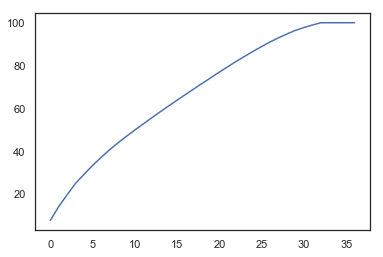

In [235]:

#lets see Cumulative Variance plot#lets se 
plt.plot(var1)

In [236]:
#From Cumulative Variance plot we can find that first 32 components are explaining nearly 100% variability of actual data.
#So lets proceed with these 32 components only
pca = PCA(n_components=32)
pca.fit(Xt1)
X_train_PC=pca.fit_transform(Xt1)


# 5. Model Training

In [237]:
# Test options and evaluation metric# 
seed = 7
scoring = 'accuracy'

In [240]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('K-NN', KNeighborsClassifier()))
models.append(('DTREE', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [241]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train_PC, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.891755 (0.005013)
LDA: 0.891202 (0.004555)
K-NN: 0.883958 (0.004866)
DTREE: 0.853766 (0.005038)
NB: 0.859241 (0.004832)
SVM: 0.893553 (0.005163)


SVM has highest Accuracy but it is taking more time compare to other algorithms for Training

6. Model Selection

[Text(0,0,'LR'),
 Text(0,0,'LDA'),
 Text(0,0,'K-NN'),
 Text(0,0,'DTREE'),
 Text(0,0,'NB'),
 Text(0,0,'SVM')]

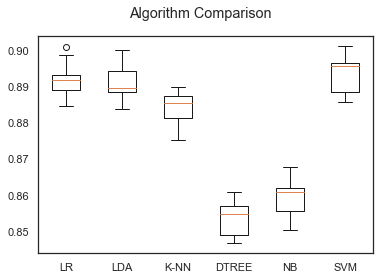

In [242]:
# Comparing Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

# 6. Making Prediction

In [244]:
#Scaling the X_validation data
XVal = scale(X_validation)

pca.fit(XVal)
X_validation_PC=pca.fit_transform(XVal)

In [255]:
# Make predictions on validation dataset Comparing LR model Vs K-NN
lr = KNeighborsClassifier()
lr.fit(X_train_PC, Y_train)
predictions = lr.predict(X_validation_PC)
print("Accuracy : ", accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy :  0.8836669246931328
[[7808  219]
 [ 833  183]]
             precision    recall  f1-score   support

         no       0.90      0.97      0.94      8027
        yes       0.46      0.18      0.26      1016

avg / total       0.85      0.88      0.86      9043



In [248]:
# Make predictions on validation dataset Comparing LR model Vs K-NN
lr = LogisticRegression()
lr.fit(X_train_PC, Y_train)
predictions = lr.predict(X_validation_PC)
print("Accuracy : ", accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy :  0.8828928452947031
[[7744  283]
 [ 776  240]]
             precision    recall  f1-score   support

         no       0.91      0.96      0.94      8027
        yes       0.46      0.24      0.31      1016

avg / total       0.86      0.88      0.87      9043



********** Just to give a better view of the confusion matrix *****************

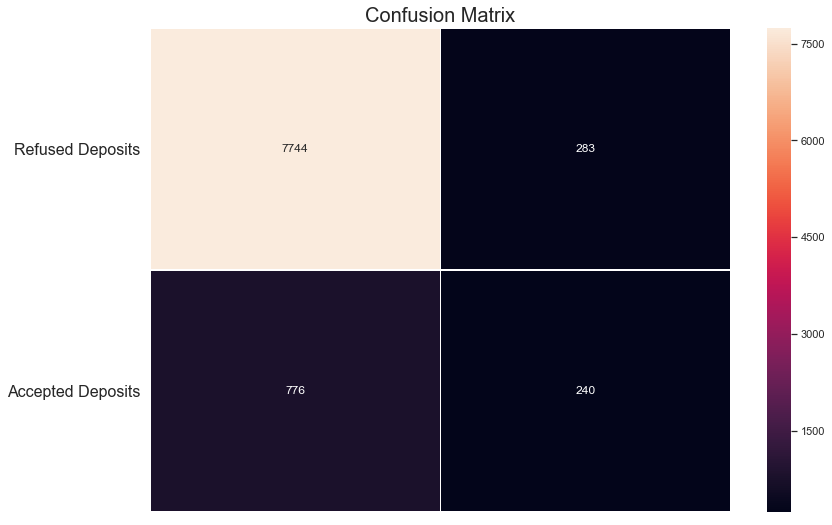

In [253]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_validation, predictions)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused Deposits', 'Accepted Deposits'], fontsize=16, rotation=360)
plt.show()

True Negatives (Top-Left Square): This is the number of correctly classifications of the "No" class or potenial clients that are not willing to suscribe a term deposit. 


False Negatives (Top-Right Square): This is the number of incorrectly classifications of the "No" class or potential clients that are not willing to suscribe a term depositt. 


False Positives (Bottom-Left Square): This is the number of incorrectly classifications of the "Yes" class or potential clients that are willing to suscribe a term deposit. 


True Positives (Bottom-Right Square): This is the number of correctly classifications of the "Yes" class or potenial clients that are willing to suscribe a term deposit.

# As we can see clearly from the above comparison, LR model is a better choice as compared the K-NN. Thought the accuracy is very close knit in both the models but the precision and f1-score are better for LR model. Hence I will suggest the bank to go with the LR model for making the next set of predictions efficient.